In [1]:
import pandas as pd

data = pd.concat([
    pd.read_csv(f"data/{year}.csv")
    for year in range(2020, 2024 + 1)
]).reset_index().drop(columns=["index"])

data

,orig_upb,defaulted,net
0,308000,False,9323.34
1,207000,False,5563.36
2,215000,False,15669.95
3,319000,False,10563.77
4,362000,False,26961.80
...,...,...,...
2799005,439000,False,4479.28
2799006,387000,False,8534.90
2799007,433000,False,4418.06
2799008,332000,False,3174.47


[]

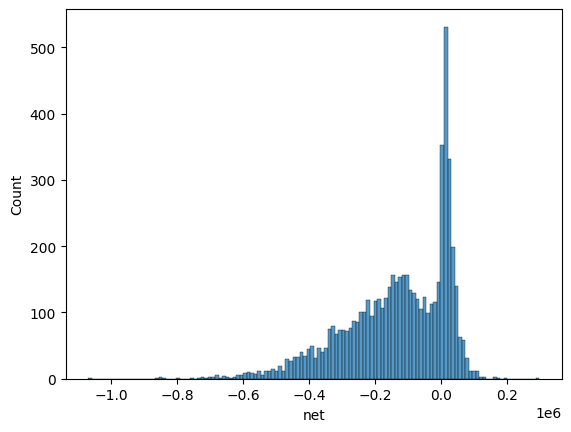

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(
    data=data[data["defaulted"]],
    x="net",
    bins=128
)

plt.plot()

In [3]:
import numpy as np

def simulate_portfolio(
    data: pd.DataFrame,
    default_rate: float = None,
    N=10000,
    n=100
) -> np.ndarray:
    defaulted = data["defaulted"]

    if default_rate is None:
        default_rate = defaulted.mean()

    n_paid = int(n * (1 - default_rate))
    n_defaulted = int(n * default_rate)

    investment_paid = data["orig_upb"][~defaulted].values
    investment_defaulted = data["orig_upb"][defaulted].values

    net_paid = data["net"][~defaulted].values
    net_defaulted = data["net"][defaulted].values

    index_paid = np.random.randint(0, len(net_paid), size=(N, n_paid))
    index_defaulted = np.random.randint(0, len(net_defaulted), size=(N, n_defaulted))

    investment = np.take(investment_paid, index_paid).sum(axis=1) + \
        np.take(investment_defaulted, index_defaulted).sum(axis=1)
    net = np.take(net_paid, index_paid).sum(axis=1) + \
        np.take(net_defaulted, index_defaulted).sum(axis=1)

    return net / investment, net

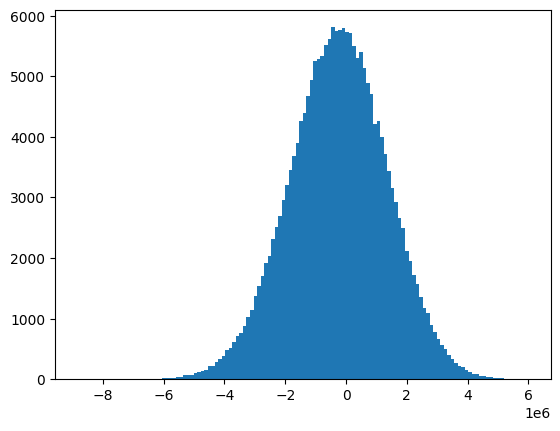

In [4]:
# 2 "levers": adjust house prices or adjust default rate

returns, net = simulate_portfolio(
    data,
    N=200_000,
    n=1_000,
    default_rate=0.1
)

plt.hist(
    net,
    bins=128
)
plt.show()